In [14]:
import numpy as np
from collections import deque
import control
import torch
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
saveFigs = True
FigDim1 = 3.0
FigDim2 = 1.5

from DeterministicPolicyGradient import DDPGagent
from utils import *
from ExtendedKF import *
from Example_system import *
from sqrtm import sqrtm
import time
import pylab as pl
from IPython import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deviceCPU = "cpu"
print(device)

cpu


In [15]:
# Define model: dynamics, dynamics gradients, and noise covariances.
model = Model(stateDynamics, measurementDynamics, Q, R)
# Define information state: (mean, covariance), from an extended Kalman Fitler.
x0=torch.tensor([[0.1, 0.1, 0.1]])
P0=torch.diag(torch.tensor([0.5,0.5,0.5]))
Hyperstate = Extended_KF(x0, P0, model)
hidden_size = 64
actor_lr = 1e-5# * 10
critic_lr = actor_lr * 10
#noise = OUNoise(ru, uMax, uMin)
Horizon_Length = 32
RollOuts = 16*2
batch_size = 32#Horizon_Length# * RollOuts
gamma = 0.95
Max_reward = 500
EffectiveHorizonLength = (1 - gamma ** Horizon_Length) / (1 - gamma)
agent = DDPGagent(rx,ru, device, hidden_size, actor_lr, critic_lr, gamma, max_memory_size= batch_size * 32, tau=0.01)

In [16]:
a = []
a = [a, 1]
print(a)

[[], 1]


In [17]:
def half_vectorize(A):
    n = A.shape[0]
    m = round((n ** 2 + n)/2)
    v = torch.zeros(m, 1)
    k = 0
    for i in range(n):
        for j in range(n):
            if (i <= j):
                v[k,0] = A[i,j]
                k += 1
    return v
            
        

0


RuntimeError: output with shape [] doesn't match the broadcast shape [1, 1]

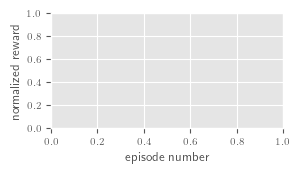

In [18]:

rewards = []
avg_rewards = []
EpisodesNumber = 1000
fig= plt.figure(figsize=(FigDim1,FigDim2))
pl.style.use('ggplot')
pl.rc('xtick', labelsize=7) #fontsize of the x tick labels
pl.rc('ytick', labelsize=7) #fontsize of the y tick labels
pl.xlabel('episode number', fontsize=9)  
pl.ylabel('normalized reward', fontsize=9) 
pl.rc('text', usetex=True)

for episode in range(EpisodesNumber):
    episode_reward = 0
    print(episode)
    ExplorationGamma = (EpisodesNumber - episode) / EpisodesNumber
    if (episode%200==0 & episode>1):
        print()
        #agent.critic_learning_rate = agent.critic_learning_rate * 1/2
        #agent.actor_learning_rate = agent.actor_learning_rate * 1/2
    for jj in range(RollOuts):
        print(jj)
        Hyperstate.ChangeInitialStates(torch.rand(rx, 1), torch.diag(torch.rand(rx,)))
        for step in range(Horizon_Length):
            state = torch.cat((Hyperstate.Mean, half_vectorize(Hyperstate.Covariance))).T.to(device)
            action = agent.get_action(state).to(deviceCPU)
            action = torch.atleast_2d(action + 1*ExplorationGamma * 2.0*torch.randn(1, 1)).detach()
            true_state = sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) + Hyperstate.Mean #we might need next t-step
            true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q) @ torch.randn(rx, 1)
            measurement_Plus_realization = measurementDynamics(true_state_Plus) + sqrtm(R) @ torch.randn(ry, 1)
            reward = - torch.sum((Hyperstate.Mean) ** 2 + Hyperstate.Covariance + action ** 2) ###########################
            if reward < -Max_reward:
                reward = torch.tensor([[-Max_reward]])
            Hyperstate.ApplyEKF(action, measurement_Plus_realization)
            new_state = torch.cat((Hyperstate.Mean, half_vectorize(Hyperstate.Covariance)))

            reward = reward.detach() / Max_reward 
            #reward = reward.detach().numpy() / Max_reward 
            agent.memory.push(state, action, new_state.T, reward)
            state = new_state
            episode_reward += reward * gamma ** step
    if len(agent.memory) >= batch_size:
        for jjj in  range(4):
            agent.update_critic(batch_size)
    for jjj in  range(1):
        agent.update_actor(batch_size*1)

    rewards.append(episode_reward.numpy() / (EffectiveHorizonLength * RollOuts) + 1)
    avg_rewards.append(np.mean(rewards[-10:]))
    if episode%10==0:
        pl.plot(avg_rewards, 'r')
        pl.title(round(avg_rewards[-1], 3))
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.001)




In [ ]:
gx = torch.zeros(ry,)
gx = torch.tanh(torch.tensor([-2]))
print(gx)

tensor([-0.9640])


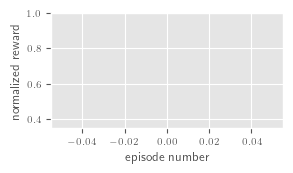

In [ ]:
plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('episode number', fontsize=9)  
plt.ylabel('normalized reward', fontsize=9) 
plt.rc( 'text', usetex=True )
plt.plot(avg_rewards)
plt.ylim([0.35, 1])
if saveFigs==True:
    plt.savefig('Figures/Example1_avgReward.pdf',bbox_inches ="tight")
plt.show()

In [ ]:
K = agent.actor.forward#get_action
t = torch.atleast_2d(torch.linspace(-7, 7, 100))

plt.figure()
N=200
x=torch.linspace(-15,15,N)
y=torch.linspace(0,12,N)
xx, yy = torch.meshgrid(x,y)
uu = xx - 0.1

for i in range(N):
    for j in range(N):
        state = torch.tensor((xx[i, j], yy[i, j])).T
        state = torch.atleast_2d(state)
        uu[i, j] = K(state)

plt.contourf(xx.detach().numpy(), yy.detach().numpy(), uu.detach().numpy())
plt.colorbar()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/zc/g4jpfwpj56g0f8xnsw3h6qw80000gn/T/ipykernel_86661/1287869728.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  state = torch.tensor((xx[i, j], yy[i, j])).T


RuntimeError: running_mean should contain 2 elements not 9

<Figure size 640x480 with 0 Axes>

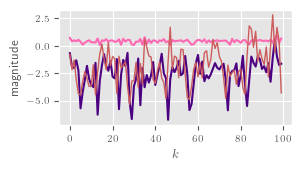

In [ ]:
T = 100
x = np.ones(T)
P = np.ones(T)
u = np.ones(T)
x_true=np.ones(T)

StateReq = deque([])
ActionReq = deque([])


Hyperstate.ChangeInitialStates(torch.atleast_2d(torch.randn(1, 1)), torch.atleast_2d(torch.rand(1, 1)))
true_state = torch.sqrt(Hyperstate.Covariance) * torch.randn(1, 1) + Hyperstate.Mean #we might need next t-step

for k in range(T):
    state = torch.cat((Hyperstate.Mean, Hyperstate.Covariance)).T
    action = K(state)
    action = torch.atleast_2d(action.detach())
    true_state_Plus = stateDynamics(true_state, action) + torch.sqrt(Q) * torch.randn(1, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus) + torch.sqrt(R) * torch.randn(1, 1)
    StateReq.append(state)
    ActionReq.append(action)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
    x_true[k] = true_state[0,0].detach().numpy()


for i in range(T):
    A = StateReq[i].detach().numpy()
    x[i] = A[0,0]
    P[i] = A[0,1]
    A = ActionReq[i].detach().numpy()
    u[i] = A[0,0]

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 
plt.rc( 'text', usetex=True )

k=56
plt.plot(range(T), x, color=list(colors.cnames)[k+4])
plt.plot(range(T), P, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true, linewidth = 1, color=list(colors.cnames)[k+3])

if saveFigs==True:
   plt.savefig('Figures/Example1_ReinfLearn.pdf',bbox_inches ="tight")


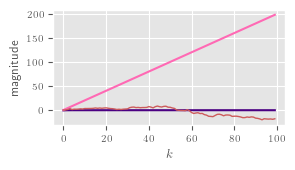

In [ ]:
Klqr_tensor = torch.from_numpy(Klqr)
x = np.ones(T)
P = np.ones(T)
x_true=np.ones(T)

StateReq = deque([])
ActionReq = deque([])

Hyperstate.ChangeInitialStates(torch.atleast_2d(torch.randn(1, 1)), torch.atleast_2d(torch.rand(1, 1)))
true_state = torch.sqrt(Hyperstate.Covariance) * torch.randn(1, 1) + Hyperstate.Mean 

for k in range(T):
    state = torch.cat((Hyperstate.Mean, Hyperstate.Covariance)).T
    action = -Klqr_tensor * (state[0,0]) 
    action = action.clip(-5, 5)
    action = torch.atleast_2d(action.detach())
    true_state_Plus = stateDynamics(true_state, action) + torch.sqrt(Q) * torch.randn(1, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus) + torch.sqrt(R) * torch.randn(1, 1)
    StateReq.append(state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
    x_true[k] = true_state[0,0].detach().numpy()

for i in range(T):
    A = StateReq[i].detach().numpy()
    x[i] = A[0,0]
    P[i] = A[0,1]

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
#plt.ylabel('$k$', fontsize=9) 
plt.ylabel('magnitude', fontsize=9) 
plt.rc( 'text', usetex=True )
#plt.ylim([-500, 500])
k=56
plt.plot(range(T), x, color=list(colors.cnames)[k+4])
plt.plot(range(T), P, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true, linewidth = 1,color=list(colors.cnames)[k+3])
if saveFigs==True:
    plt.savefig('Figures/Example1_LQR.pdf',bbox_inches ="tight")


In [ ]:

import pickle

with open('StateFeedbackGainFunction.pkl', 'wb') as outp:
    pickle.dump(K, outp, pickle.HIGHEST_PROTOCOL)


with open('StateFeedbackGainFunction.pkl', 'rb') as inp:
    K1 = pickle.load(inp)
    print(K1)

A = torch.tensor([1,1])
print(K1(torch.atleast_2d(A)))

<bound method Actor.forward of Actor(
  (OneFunc): Sequential(
    (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2, out_features=64, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=64, out_features=1, bias=True)
    (8): Tanh()
  )
)>
tensor([[-2.7086]], grad_fn=<MulBackward0>)
